Translation vector of camera 1 in the object ref. frame:
[[ 0.29875862]
 [ 0.07183316]
 [-0.2036783 ]]
Translation vector of camera 2 in the object ref. frame:
[[ 0.18386562]
 [ 0.04191411]
 [-0.37681682]]


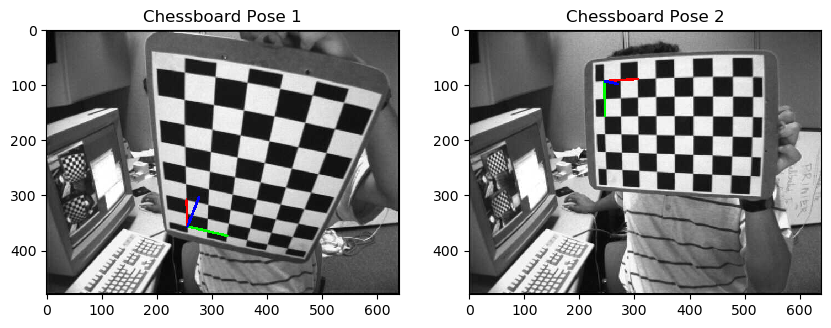

[[0. ]
 [0. ]
 [0.5]]

Euclidean Homography:
[[ 0.22153449 -0.99493323  0.1140658 ]
 [ 0.67762013  0.18393688 -0.153025  ]
 [ 0.33000662 -0.56834546  1.        ]]
Euclidean Homography 2:
[[ 0.2081386  -0.90587948  0.24422584]
 [ 0.565882   -0.0115421   0.09567272]
 [ 0.26226584 -0.83502609  1.        ]]


findHomography H:
[[ 3.29033933e-01 -1.24413881e+00  5.36476909e+02]
 [ 6.96976391e-01 -8.93590907e-02 -8.03406850e+01]
 [ 4.05117296e-04 -1.07974010e-03  1.00000000e+00]]
homography from camera displacement:
[[ 4.16056997e-01 -1.30688902e+00  5.53705546e+02]
 [ 7.91758424e-01 -6.34124482e-02 -1.08277003e+02]
 [ 5.92635728e-04 -1.02065172e-03  1.00000000e+00]]
homography from absolute camera poses:
[[ 3.13156367e-01 -1.19979034e+00  5.69903804e+02]
 [ 5.67853754e-01 -3.15613298e-01  1.19109562e+02]
 [ 4.07970869e-04 -1.29893513e-03  1.00000000e+00]]



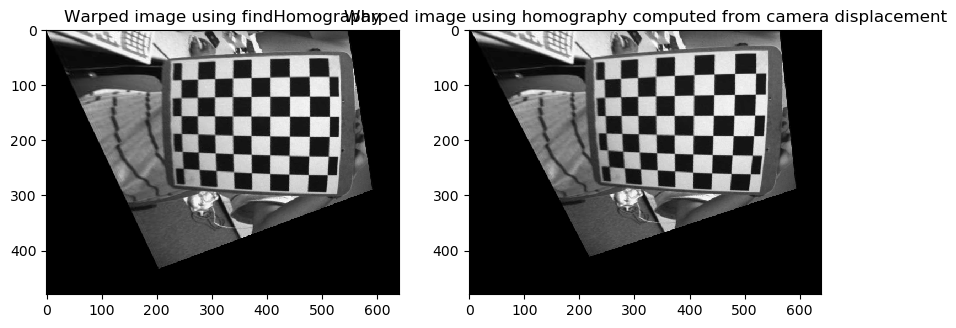

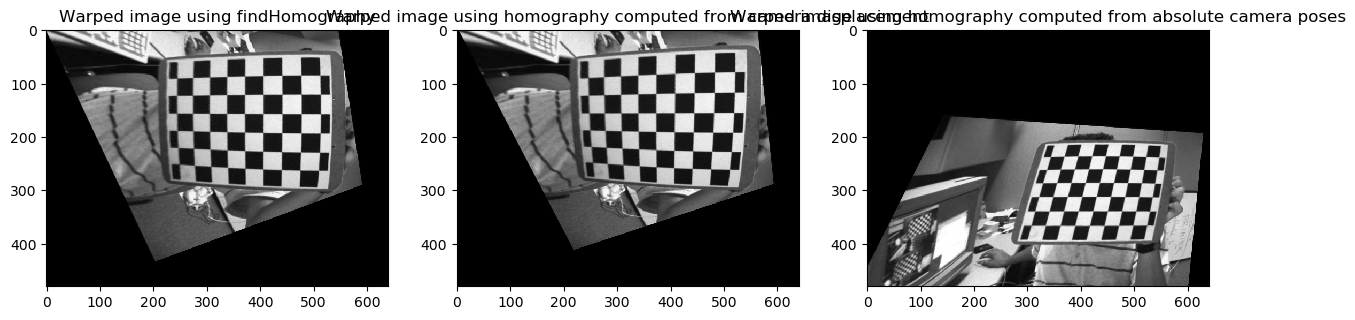

In [3]:
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np

# Enumeration for the pattern type
CHESSBOARD = 0
CIRCLES_GRID = 1
ASYMMETRIC_CIRCLES_GRID = 2

def calc_chessboard_corners(board_size, square_size, pattern_type=CHESSBOARD):
    corners = []
    if pattern_type in (CHESSBOARD, CIRCLES_GRID):
        for i in range(board_size[1]):
            for j in range(board_size[0]):
                corners.append((j * square_size, i * square_size, 0))
    elif pattern_type == ASYMMETRIC_CIRCLES_GRID:
        for i in range(board_size[1]):
            for j in range(board_size[0]):
                corners.append(((2 * j + i % 2) * square_size, i * square_size, 0))
    else:
        raise ValueError("Unknown pattern type")
    return np.array(corners, dtype=np.float32)

def compute_homography(R_1to2, tvec_1to2, d_inv, normal):
    homography = R_1to2 + d_inv * np.dot(tvec_1to2, normal.T)
    return homography

def compute_homography_from_poses(R1, tvec1, R2, tvec2, d_inv, normal):
    homography = np.dot(R2, R1.T) + d_inv * (np.dot(-R2, np.dot(R1.T, tvec1)) + tvec2) @ normal.T
    return homography

def compute_C2MC1(R1, tvec1, R2, tvec2):
    R_1to2 = np.dot(R2, R1.T)
    tvec_1to2 = np.dot(R2, -np.dot(R1.T, tvec1)) + tvec2
    return R_1to2, tvec_1to2

def homography_from_camera_displacement(img1_path, img2_path, pattern_size, square_size, intrinsics_path):
    img1 = cv2.imread(cv2.samples.findFile(img1_path))
    img2 = cv2.imread(cv2.samples.findFile(img2_path))

    # Find chessboard corners in both images
    found1, corners1 = cv2.findChessboardCorners(img1, pattern_size)
    found2, corners2 = cv2.findChessboardCorners(img2, pattern_size)

    if not found1 or not found2:
        print("Error: Cannot find the chessboard corners in both images.")
        return

    # Compute object points
    object_points = calc_chessboard_corners(pattern_size, square_size)

    # Load camera intrinsics
    fs = cv2.FileStorage(cv2.samples.findFile(intrinsics_path), cv2.FileStorage_READ)
    camera_matrix = fs.getNode("camera_matrix").mat()
    dist_coeffs = fs.getNode("distortion_coefficients").mat()

    # Estimate poses
    _, rvec1, tvec1 = cv2.solvePnP(object_points, corners1, camera_matrix, dist_coeffs)
    _, rvec2, tvec2 = cv2.solvePnP(object_points, corners2, camera_matrix, dist_coeffs)

    # Convert poses into the object coordinate system
    R1, _ = cv2.Rodrigues(rvec1)
    R2, _ = cv2.Rodrigues(rvec2)
    tvec1_obj = np.dot(R1.T, -tvec1)
    tvec2_obj = np.dot(R2.T, -tvec2)

    # Convert back to the camera coordinate system
    assert np.allclose(np.dot(R1, -tvec1_obj), tvec1), f"Mismatching transformation tvec1: {tvec1}, R1*tvec1_obj: {np.dot(R1, tvec1_obj)}"
    
    for i in range(1,3):
        # Check that the translation vector tvec{i}_obj has same magnitude as the original tvec{i}
        assert np.linalg.norm(tvec1) == np.linalg.norm(tvec1_obj)
        print(f"Translation vector of camera {i} in the object ref. frame:\n{eval(f'tvec{i}_obj')}")

    # Draw chessboard poses
    img1_copy_pose = img1.copy()
    img2_copy_pose = img2.copy()
    cv2.drawFrameAxes(img1_copy_pose, camera_matrix, dist_coeffs, rvec1, tvec1, 2 * square_size)
    cv2.drawFrameAxes(img2_copy_pose, camera_matrix, dist_coeffs, rvec2, tvec2, 2 * square_size)
    img_draw_poses = np.hstack((img1_copy_pose, img2_copy_pose))
    # Show chessboard poses
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(cv2.cvtColor(img1_copy_pose, cv2.COLOR_BGR2RGB))
    ax[0].set_title("Chessboard Pose 1")
    ax[1].imshow(cv2.cvtColor(img2_copy_pose, cv2.COLOR_BGR2RGB))
    ax[1].set_title("Chessboard Pose 2")
    plt.show()

    # Compute camera displacement
    R1, _ = cv2.Rodrigues(rvec1)
    R2, _ = cv2.Rodrigues(rvec2)
    R_1to2, t_1to2 = compute_C2MC1(R1, tvec1, R2, tvec2)
    rvec_1to2, _ = cv2.Rodrigues(R_1to2)

    # Compute plane normal at camera pose 1
    normal = np.array([[0], [0], [1]])
    normal1 = np.dot(R1, normal)

    # Compute plane distance to the camera frame 1
    origin = np.zeros((3, 1))
    origin1 = np.dot(R1, origin) + tvec1
    d_inv1 = 1.0 / np.dot(normal1.T, origin1)

    origin2 = np.dot(R2, origin) + tvec2
    d_inv2 = 1.0 / np.dot(normal1.T, origin2)

    # Compute homography from camera displacement
    homography_euclidean = compute_homography(R_1to2, t_1to2, d_inv1, normal1)
    homography = np.dot(np.dot(camera_matrix, homography_euclidean), np.linalg.inv(camera_matrix))
    homography /= homography[2, 2]
    homography_euclidean /= homography_euclidean[2, 2]

    # Define the desired pose for camera 2 in the object coordinate system
    R2_new = np.eye(3)
    
    # Transform the desired pose to the camera coordinate system
    tvec2_new = np.array([0,0,0.5]).reshape(3,1)
    print(tvec2_new)

    # Compute homography using absolute camera poses (for verification)
    homography_euclidean2 = compute_homography_from_poses(R1, tvec1, R2_new, tvec2_new, d_inv1, normal1)
    homography2 = np.dot(np.dot(camera_matrix, homography_euclidean2), np.linalg.inv(camera_matrix))
    homography2 /= homography2[2, 2]
    homography_euclidean2 /= homography_euclidean2[2, 2]

    homography_euclidean3 = compute_homography_from_poses(R2, tvec2, R2_new, tvec2_new, d_inv2, normal1)
    homography3 = np.dot(np.dot(camera_matrix, homography_euclidean3), np.linalg.inv(camera_matrix))
    homography3 /= homography3[2, 2]
    homography_euclidean3 /= homography_euclidean3[2, 2]
    
    print(f"\nEuclidean Homography:\n{homography_euclidean}")
    print(f"Euclidean Homography 2:\n{homography_euclidean2}\n")

    # Estimate homography using findHomography (for comparison)
    H, _ = cv2.findHomography(corners1, corners2)
    print(f"\nfindHomography H:\n{H}")
    print(f"homography from camera displacement:\n{homography}")
    print(f"homography from absolute camera poses:\n{homography2}\n")

    # Warp chessboard using the computed homographies
    img1_warp = cv2.warpPerspective(img1, H, img1.shape[1::-1])
    img1_warp_custom = cv2.warpPerspective(img1, homography, img1.shape[1::-1])
    img_draw_compare = np.hstack((img1_warp, img1_warp_custom))
    

    # Show the comparison of warped images
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(img1_warp)
    ax[0].set_title("Warped image using findHomography")
    ax[1].imshow(img1_warp_custom)
    ax[1].set_title("Warped image using homography computed from camera displacement")
    plt.show()

    img1_warp_custom2 = cv2.warpPerspective(img1, homography2, img1.shape[1::-1])
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(img1_warp)
    ax[0].set_title("Warped image using findHomography")
    ax[1].imshow(img1_warp_custom)
    ax[1].set_title("Warped image using homography computed from camera displacement")
    ax[2].imshow(img1_warp_custom2)
    ax[2].set_title("Warped image using homography computed from absolute camera poses")
    
    img2_warp_custom3 = cv2.warpPerspective(img2, homography3, img2.shape[1::-1])
    plt.imshow(img2_warp_custom3)
    
    plt.show()


# Load the image
this_dir: str = os.path.abspath("")
assets_dir: str = os.path.join(this_dir, "..", "assets")
img_dir: str = os.path.join(assets_dir, "extrinsics/validation/")

# Example parameters (these should be modified to fit your use case)
pattern_size = (9, 6)
square_size = 0.025  # meters
img1_path = img_dir + 'left02.jpg'
img2_path = img_dir + 'left01.jpg'
intrinsics_path = img_dir + 'left_intrinsics.yml'

# Run the homography computation
homography_from_camera_displacement(img1_path, img2_path, pattern_size, square_size, intrinsics_path)
